In [ ]:
# uncomment to install dependencies
# !pip install datasets

Including python dependencies from '/content/drive/My Drive/colab_packages'


In [ ]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

# change to correct working directory
import os
os.chdir("/content/drive/MyDrive/repositories/deepfake-detection")
os.listdir() # verify content

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['sc4001_example.ipynb',
 'models',
 'references',
 'reports',
 'README.md',
 'datasets',
 '.gitignore',
 'src',
 'environment.yml',
 '.git',
 'temp.jpg']

In [2]:
# import library dependencies
import io
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import cv2
from PIL import Image
from itertools import islice
import tqdm

In [ ]:
# import local dependencies
from src.utils.adapters.datasets.wilddeepfake import load_streaming_dataset, create_data_loaders
import src.utils.config as config

In [ ]:
dataset_name = "xingjunm/WildDeepfake"
max_samples = 14000  # For quick development, remove for full dataset
batch_size = 16
num_workers = 2
seed = config.SEED
save_path = 'models/mobilenet_deepfake.pth'

# Set seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# Determine device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset and create loaders
datasets = load_streaming_dataset(
    dataset_name,
    max_samples=max_samples,
    seed=seed
)
train_loader, val_loader, test_loader = create_data_loaders(
    datasets,
    batch_size=batch_size,
    num_workers=num_workers
)

Using device: cpu
Loading dataset: xingjunm/WildDeepfake
Loading streaming dataset: xingjunm/WildDeepfake


Resolving data files:   0%|          | 0/963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/157 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 14000/14000 [01:31<00:00, 152.35it/s]

Finished processing. Total: 14000
Train: 11200, Val: 1400, Test: 1400



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
train_loader.dataset.samples[0]

{'png': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 '__key__': './306/real/142/4389',
 '__url__': 'hf://datasets/xingjunm/WildDeepfake@f3835aaf281dd9f8d79b51c4e02f050d3f7af0b4/deepfake_in_the_wild/real_train/306.tar.gz',
 'label': 0}

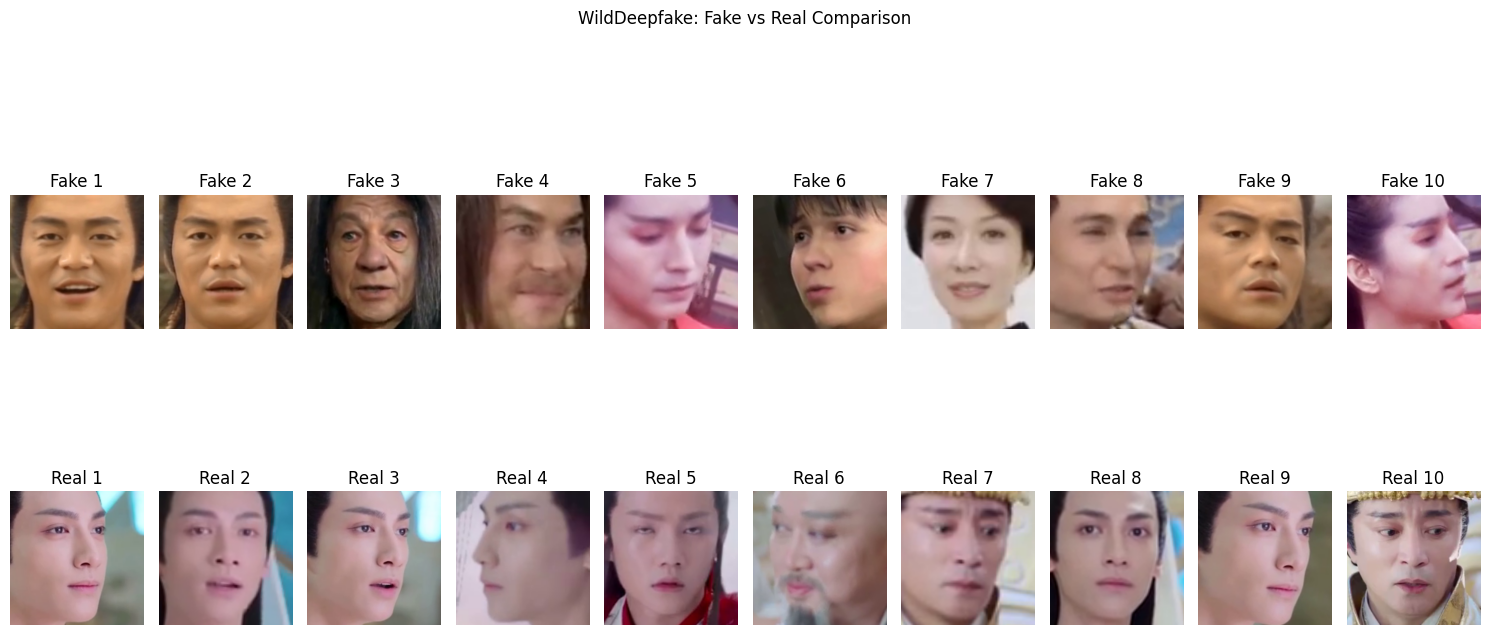

In [ ]:
def compare_fake_vs_real(dataset, num_pairs=10):
    """Display fake and real images side by side"""
    fake_samples = []
    real_samples = []

    # Collect samples
    for sample in dataset:
        label = sample["label"]
        if label == 1 and len(fake_samples) < num_pairs:
            fake_samples.append(sample)
        elif label == 0 and len(real_samples) < num_pairs:
            real_samples.append(sample)

        if len(fake_samples) == num_pairs and len(real_samples) == num_pairs:
            break

    fig, axes = plt.subplots(2, num_pairs, figsize=(15, 8))

    # Display fake images in top row
    for i, sample in enumerate(fake_samples):
        axes[0, i].imshow(sample['png'])
        axes[0, i].set_title(f"Fake {i+1}")
        axes[0, i].axis('off')

    # Display real images in bottom row
    for i, sample in enumerate(real_samples):
        axes[1, i].imshow(sample['png'])
        axes[1, i].set_title(f"Real {i+1}")
        axes[1, i].axis('off')

    plt.suptitle("WildDeepfake: Fake vs Real Comparison")
    plt.tight_layout()
    plt.show()

    return fake_samples, real_samples

fake_samples, real_samples = compare_fake_vs_real(train_loader.dataset.samples)

In [8]:
def ela(image, quality=95, scale=10, as_gray=True):
    """
    Performs Error Level Analysis (ELA) on an image.

    Args:
        image_path (str): The path to the image file.
        scale (int): The scale factor for resizing the image. Default is 10.

    Returns:
        ela_image (np.array): The ELA image.
    """
    # Load the image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Save to JPEG in memory at given quality
    buffer = io.BytesIO()
    image.save(buffer, 'JPEG', quality=quality)
    buffer.seek(0)
    recompressed = Image.open(buffer)

    # Compute absolute difference
    original_arr = np.array(image, dtype=np.int16)
    recompressed_arr = np.array(recompressed, dtype=np.int16)
    diff = np.abs(original_arr - recompressed_arr)

    # Scale differences
    ela_image = np.clip(diff * scale, 0, 255).astype(np.uint8)

    if as_gray:
      ela_image = cv2.cvtColor(ela_image, cv2.COLOR_BGR2GRAY)

    return ela_image

def rpa(ela_image):
    """
    Performs Residual Pixel Analysis (RPA) on an ELA image.

    Args:
        ela_image (np.array): The ELA image.

    Returns:
        tampered (bool): True if the image is tampered, False otherwise.
    """
    # Calculate the standard deviation of the ELA image
    stddev = np.std(ela_image)

    # Define the threshold for detecting tampered images
    threshold = 0.5

    # If the standard deviation is greater than the threshold, the image is tampered
    tampered = stddev > threshold

    return tampered

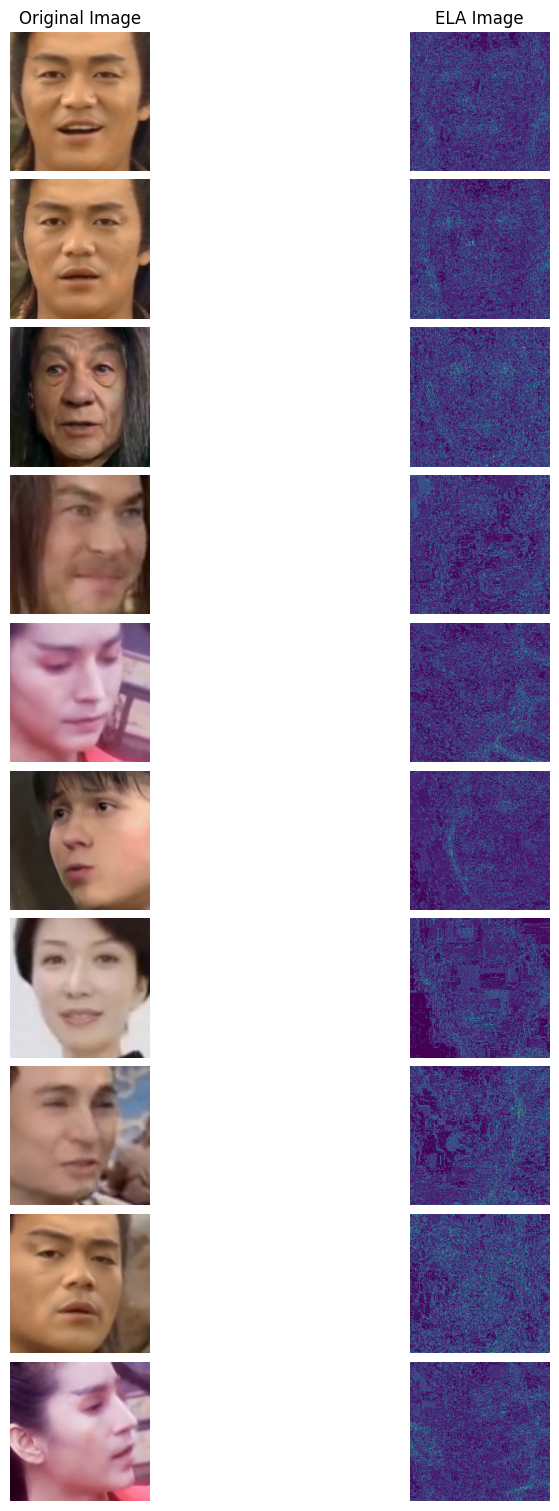

In [9]:
fig, axes = plt.subplots(len(fake_samples), 2, figsize=(8, 15), constrained_layout=True)

axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("ELA Image")

for i, sample in enumerate(fake_samples):
  original_img = sample["png"]
  ela_img = ela(original_img)
  axes[i, 0].imshow(original_img)
  axes[i, 0].axis("off")

  axes[i, 1].imshow(ela_img)
  axes[i, 1].axis("off")
plt.show()

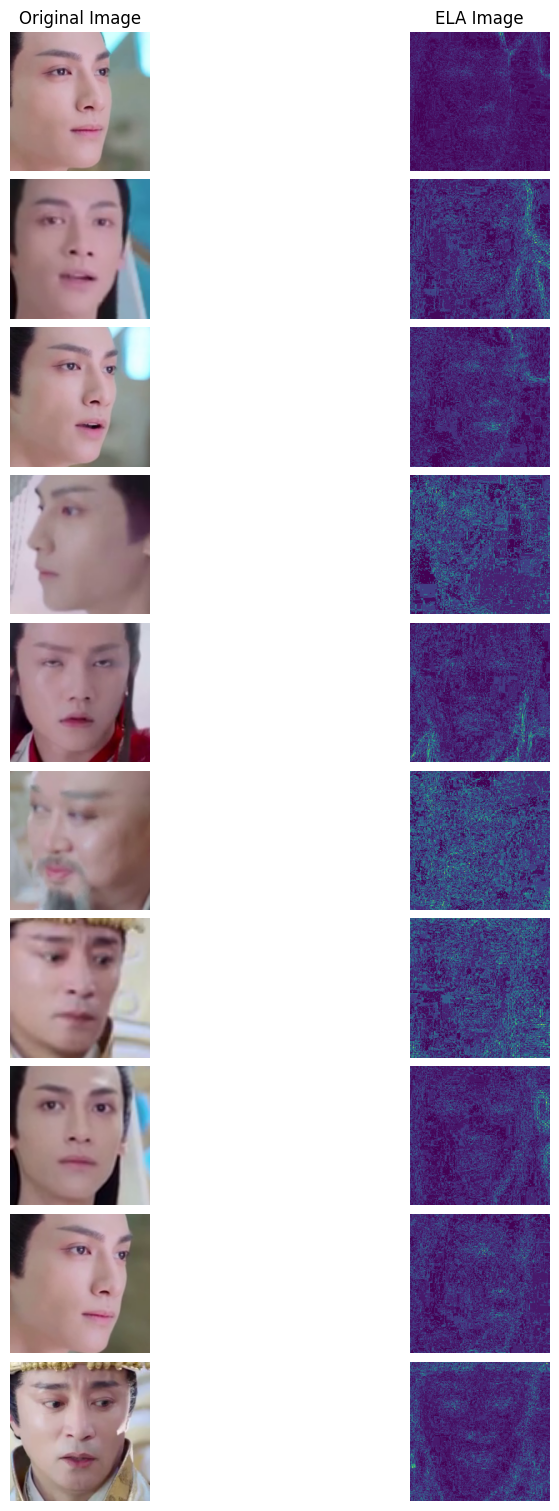

In [10]:
fig, axes = plt.subplots(len(fake_samples), 2, figsize=(8, 15), constrained_layout=True)

axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("ELA Image")
for i, sample in enumerate(real_samples):
  original_img = sample["png"]
  ela_img = ela(original_img)
  axes[i, 0].imshow(original_img)
  axes[i, 0].axis("off")

  axes[i, 1].imshow(ela_img)
  axes[i, 1].axis("off")
plt.show()

In [ ]:
tp = tn = fp = fn = 0
count = 0
t = tqdm.tqdm(total=len(train_loader.dataset.samples)) # Initialise
for sample in train_loader.dataset.samples:
  count += 1
  original_img = sample["png"]
  ela_img = ela(original_img)
  actual = sample["label"] == 1
  predicted = rpa(ela_img)
  if predicted:
    if actual: tp += 1 # deepfake detected correctly
    else: fp += 1
  else:
    if actual: fn += 1
    else: tn += 1
  t.update(1)
t.close()

100%|██████████| 11200/11200 [00:33<00:00, 337.92it/s]


In [12]:
acc = (tn + tp) / (tp + fn + tn + fp) if (tp + fn + tn + fp) != 0 else 0
recall = tp / (fn + tp) if (fn + tp) != 0 else 0
precision = tp / (fp + tp) if (fp + tp) != 0 else 0
f1_score = tp / (tp + ((fp+fn)/ 2)) if (tp + ((fp+fn) / 2)) != 0 else 0

In [13]:
print(f"Accuracy: {acc}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")

Accuracy: 0.7080357142857143
Recall: 1.0
Precision: 0.7080357142857143
F1 Score: 0.829064296915839


In [ ]:
real = fake = 0
for sample in train_loader.dataset.samples:
  if sample["label"] == 1: fake += 1
  else: real += 1
print(f"Fake: {fake}")
print(f"Real: {real}")

Fake: 7930
Real: 3270
